## The goal of this notebook is to explore gas chromatography mass spectrometry (GC-MS) data and apply classification techniques to diagnose Crohn's Disease

#### Imports and functions

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from tqdm.notebook import tqdm

In [2]:
def confidence_interval(alpha, stats):
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    print(f'{alpha*100} confidence interval {round(lower*100, 2)} and {round(upper*100, 2)}')
    
    return lower, upper

In [3]:
def to_dataframe(mat):
    X = mat['XTIC']
    y = mat['CLASS']
    df = pd.DataFrame(X)
    df.index = [x for x in [x for x in mat['SAM'] for x in x] for x in x]
    
    return df, y

def print_counts(y):
    unlisted = [x for x in y for x in x]
    control_count = unlisted.count(1)
    disease_count = unlisted.count(2)
    print(f'n controls: {control_count}\nn disease: {disease_count}')

def pca_(X, n):
    sscaler = StandardScaler()
    sscaler.fit(X)
    scaled_X = sscaler.transform(X)
    
    pca = PCA(n_components = n)
    pca.fit(scaled_X)
    pca_results = pca.transform(scaled_X)
    print(f'pca shape {np.shape(pca_results)}')
    
    return pca, pca_results

def plot_pca(Xs, ys, pcas):

    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15,12))
    ax = ax.flatten()
    
    
    for ind, axes in enumerate(ax):
        df = pd.DataFrame(pca_Xs[ind])
        
        scatter = axes.scatter(x=df[0], y=df[1], c = ys[ind])

        legend1 = axes.legend(*scatter.legend_elements(),
                            loc="right", title="Classes")

        axes.add_artist(legend1)
        axes.set_title(f'{sample_types[ind]} PCA')
        axes.set_xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0], 2)*100}% of var. explained)')
        axes.set_ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1], 2)*100}% of var. explained)')


def gridsearch_svc(X, y):
    best_scores = []
    best_params_l = []
    models = []
    for cv in tqdm(range(4,6)):
        grid = GridSearchCV(pipeline, param_grid=check_params, cv=cv, scoring='accuracy', n_jobs = -1)
        model = grid.fit(X, np.ravel(y))
        best_params_l.append(grid.best_params_)
        best_scores.append(grid.best_score_)
        models.append(grid)
    df = pd.concat([pd.DataFrame(best_params_l), pd.Series(best_scores, name = 'accuracy')], axis=1)
    best_result = df.iloc[df.accuracy.idxmax()]
    
    return best_result

def bootstrap(X, y, C_, gamma_, n_iterations, n_samples_):
    data = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis = 1)
    # run bootstrap
    stats = []
    
    #saving true and false indexes to assess correctly classified % for each sample donor
    d_true = {i : 0 for i in range(len(y))}
    d_false = {i : 0 for i in range(len(y))}
    
    for i in tqdm(range(n_iterations)):
        # prepare train and test sets
        train = resample(data, replace = True, n_samples=n_samples_)
        test = data[~data.index.isin(train.index)]
        # fit model
        model = SVC(kernel='rbf', C=C_, gamma=gamma_)
        model.fit(train.iloc[:,:-1], train.iloc[:,-1])
        # evaluate model
        predictions = model.predict(test.iloc[:,:-1])
        score = accuracy_score(test.iloc[:,-1], predictions)
        stats.append(score)
        
        # counting true and false predictions by index
        true_index = test.iloc[[i for i, (x,y) in enumerate(zip(test.iloc[:, -1], predictions)) if x == y]].index
        false_index = test.iloc[[i for i, (x,y) in enumerate(zip(test.iloc[:, -1], predictions)) if x != y]].index
        
        for index in true_index:
            d_true[index] += 1
        
        for index in false_index:
            d_false[index] += 1
    
    # confidence intervals
    lower_CI, upper_CI = confidence_interval(0.95, stats)
    
    return stats, d_true, d_false

def plot_bootstrap_results(Xs, ys, n_iter):
    results_d = {}
    
    for st,X,y in zip(sampletype_accuracy.index, Xs, ys):

        C = sampletype_accuracy.at[st, 'SupVM__C']
        gamma = sampletype_accuracy.at[st, 'SupVM__gamma']
        print(f"Sample type: {st}")
        accuracy, true, false = bootstrap(X,y, C, gamma, n_iter, n_samples_=len(y))
        print(f"Median accuracy: {np.median(accuracy)}")
        results_d[st] = [accuracy, true, false]
    
    fig, axes = plt.subplots(2, 2, figsize=(24, 15))
    axes[0][0].title.set_text('blood')
    axes[0][1].title.set_text('breath')
    axes[1][0].title.set_text('urine')
    axes[1][1].title.set_text('faecal')
    sns.histplot(results_d["blood"][0], color = sns.color_palette("muted")[3], ax=axes[0, 0], kde=True).set_xlabel('accuracy')
    sns.histplot(results_d["breath"][0], color = sns.color_palette("muted")[9], ax=axes[0, 1], kde=True).set_xlabel("accuracy")
    sns.histplot(results_d["urine"][0], color = sns.color_palette("muted")[8], ax=axes[1, 0], kde=True).set_xlabel("accuracy")
    sns.histplot(results_d["faecal"][0], color = sns.color_palette("muted")[5], ax=axes[1, 1], kde=True).set_xlabel("accuracy")
    
    return results_d

def plot_patient_accuracies(results_d, sts, Xs):
    
    indexes = [df.index for df in Xs]
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 16))
    colours = [3,9,8,5]
    
    ind_accs = []
    
    for st in sts:
        true_d = results_d[st][1]
        false_d = results_d[st][2]
        index_accuracies = [(true_d[key]/(true_d[key]+false_d[key]))*100 for key in true_d.keys()]
        ind_accs.append(index_accuracies)
    
    for i,pos in zip(range(4),[(0,0),(0,1),(1,0),(1,1)]):
        axes[pos].tick_params(axis='x', rotation=90)
        axes[pos].set_ylabel('Classification accuracy')
        sns.barplot(x = indexes[i], 
                    y = ind_accs[i], 
                    ax = axes[pos[0]][pos[1]],
                    color = sns.color_palette("muted")[colours[i]]).set_xlabel('patient')

### Gas Chromatography Mass Spectrometry (GC-MS) input data
1. GC-MS provides intensity or concentration peaks representing compounds for a range of retention times i.e. the time taken for a given compound to elute out of the column. This results in a dataset representing the metabolite composition of the sample.
2. With GC-MS samples from multiple sample types, the first step is to identify the "richest" sample type for classification performance for optimum diagnostic power.

In [4]:
df_blood, y_blood = to_dataframe(loadmat('datasets/BWG_BL_CDvCTRL.mat'))
df_breath, y_breath = to_dataframe(loadmat('datasets/BWG_BR_CDvCTRL.mat'))
df_urine, y_urine = to_dataframe(loadmat('datasets/BWG_UR_CDvCTRL.mat'))
df_faecal, y_faecal = to_dataframe(loadmat('datasets/BWG_FA_CDvCTRL.mat'))

In [5]:
sample_types = ['blood', 'breath', 'urine', 'faecal']

In [6]:
df_blood.shape

(32, 4349)

In [7]:
df_breath.shape

(35, 4349)

In [8]:
df_urine.shape

(22, 4349)

In [9]:
df_faecal.shape

(23, 4349)

In [10]:
for y, sample_type in zip([y_blood, y_breath, y_urine, y_faecal],sample_types):
    print(sample_type)
    print_counts(y)

blood
n controls: 18
n disease: 14
breath
n controls: 19
n disease: 16
urine
n controls: 14
n disease: 8
faecal
n controls: 12
n disease: 11


### Building baseline SVM classifier to identify richest sample type.
* PCA for canonical dimensionality reduction.
* GridSearch for optimising hyperparams.

In [11]:
check_params= {
    'pca__n_components': [2,3,4], 
    'SupVM__C': [0.1, 0.5, 1, 10,30, 40, 50, 75, 100, 500, 1000], 
    'SupVM__gamma' : [0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]
}

pipeline = Pipeline([('scaler', StandardScaler(copy = True)), ('pca', PCA()), ('SupVM', SVC(kernel='rbf'))])

In [12]:
Xs = [df_blood,df_breath,df_urine,df_faecal]
ys = [y_blood,y_breath,y_urine,y_faecal]

sampletype_accuracy = pd.concat([gridsearch_svc(X, y) for X,y in zip(Xs,ys)], axis =1).T
sampletype_accuracy.insert(0,'index',sample_types)
sampletype_accuracy.set_index('index',inplace=True)
sampletype_accuracy.head()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

,SupVM__C,SupVM__gamma,pca__n_components,accuracy
index,,,,
blood,1.0,0.01,3.0,0.656250
breath,1.0,0.50,3.0,0.714286
urine,0.1,0.01,2.0,0.640000
faecal,1.0,0.01,3.0,0.780000


### PCA

In [13]:
blood_pca, bl_pca_array = pca_(df_blood, 3)
breath_pca, br_pca_array = pca_(df_breath, 3)
urine_pca, ur_pca_array = pca_(df_urine, 2)
faecal_pca, fa_pca_array = pca_(df_faecal, 3)

pca shape (32, 3)
pca shape (35, 3)
pca shape (22, 2)
pca shape (23, 3)


In [14]:
pca_Xs = [bl_pca_array, br_pca_array, ur_pca_array, fa_pca_array]
pcas = [blood_pca, breath_pca, urine_pca, faecal_pca]
ys = [y_blood, y_breath, y_urine, y_faecal]

In [15]:
for pca in [blood_pca, urine_pca, breath_pca, faecal_pca]:
    print(f'Total variance explained: {round(pca.explained_variance_ratio_.cumsum()[-1], 2)}')

Total variance explained: 0.85
Total variance explained: 0.86
Total variance explained: 0.96
Total variance explained: 0.71


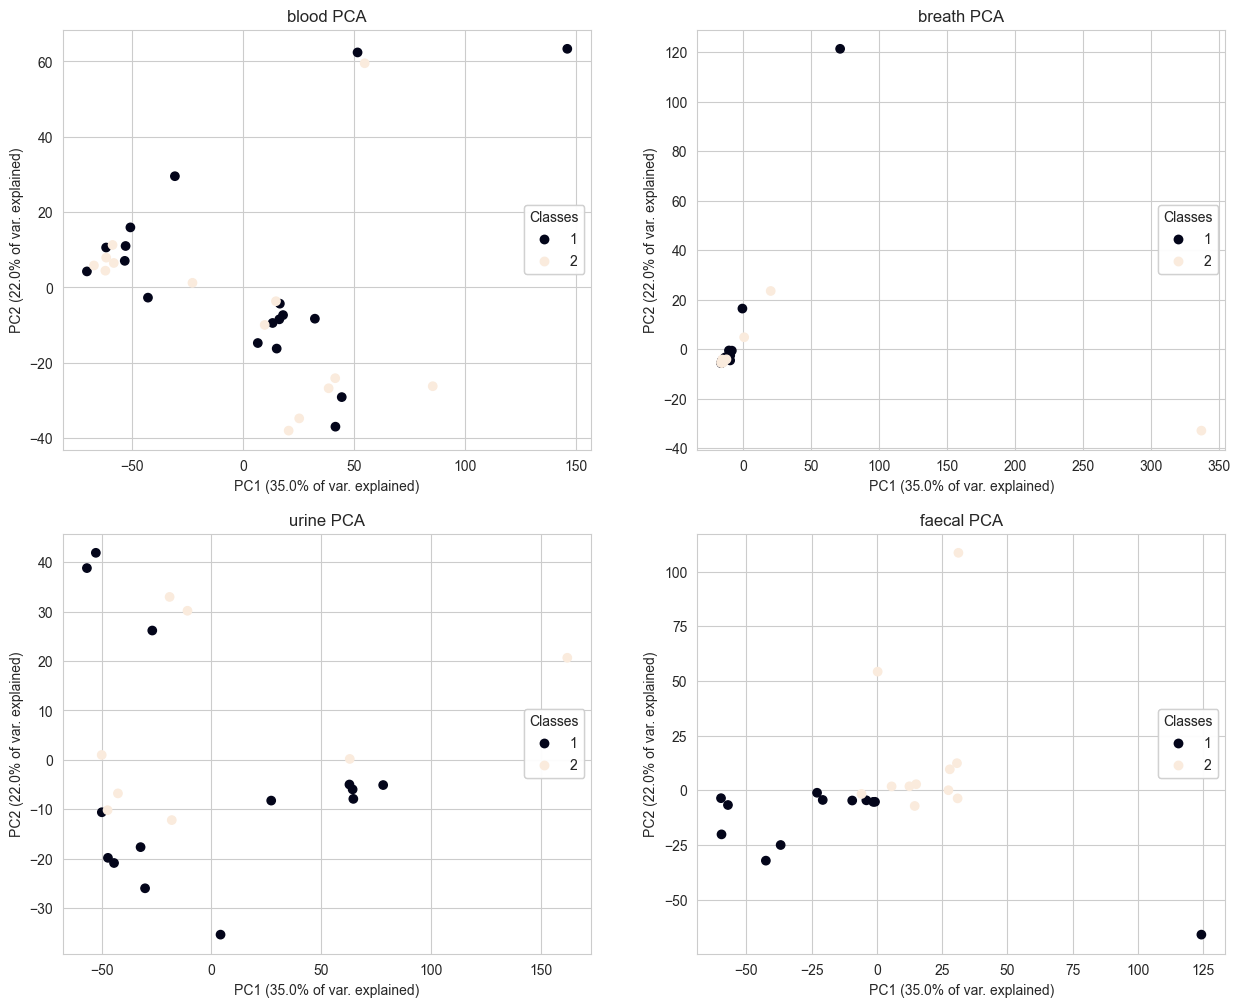

In [16]:
plot_pca(Xs = pca_Xs, ys = ys, pcas = pcas)

### Classification accuracy results of SVC classifier from bootstrap sampling

Sample type: blood


  0%|          | 0/1600 [00:00<?, ?it/s]

95.0 confidence interval 28.57 and 75.0
Median accuracy: 0.5454545454545454
Sample type: breath


  0%|          | 0/1600 [00:00<?, ?it/s]

95.0 confidence interval 25.0 and 80.0
Median accuracy: 0.5555555555555556
Sample type: urine


  0%|          | 0/1600 [00:00<?, ?it/s]

95.0 confidence interval 12.5 and 87.5
Median accuracy: 0.625
Sample type: faecal


  0%|          | 0/1600 [00:00<?, ?it/s]

95.0 confidence interval 33.33 and 100.0
Median accuracy: 0.7142857142857143


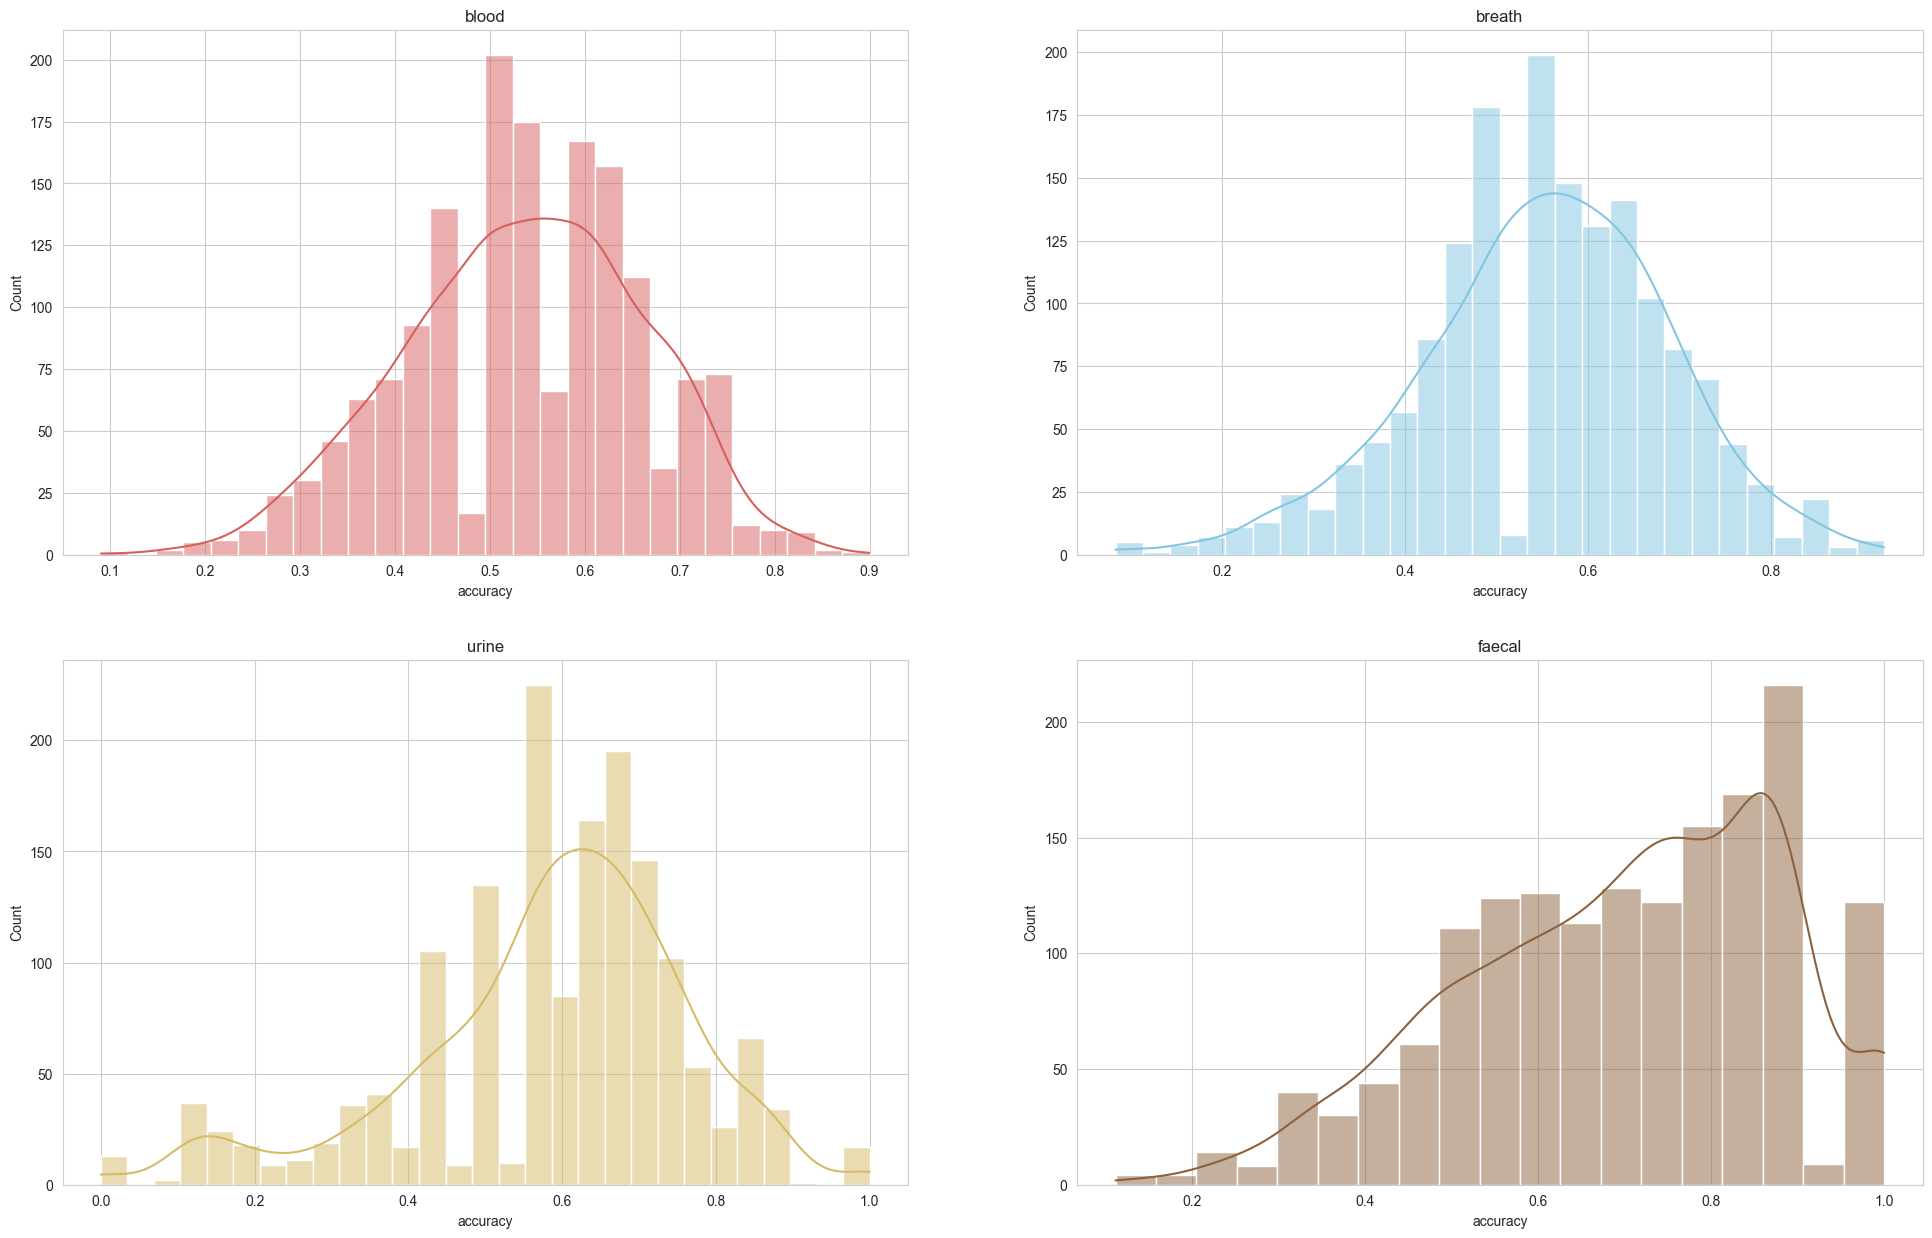

In [17]:
bootstrap_results_d = plot_bootstrap_results(Xs = pca_Xs, ys=ys, n_iter = 1600)

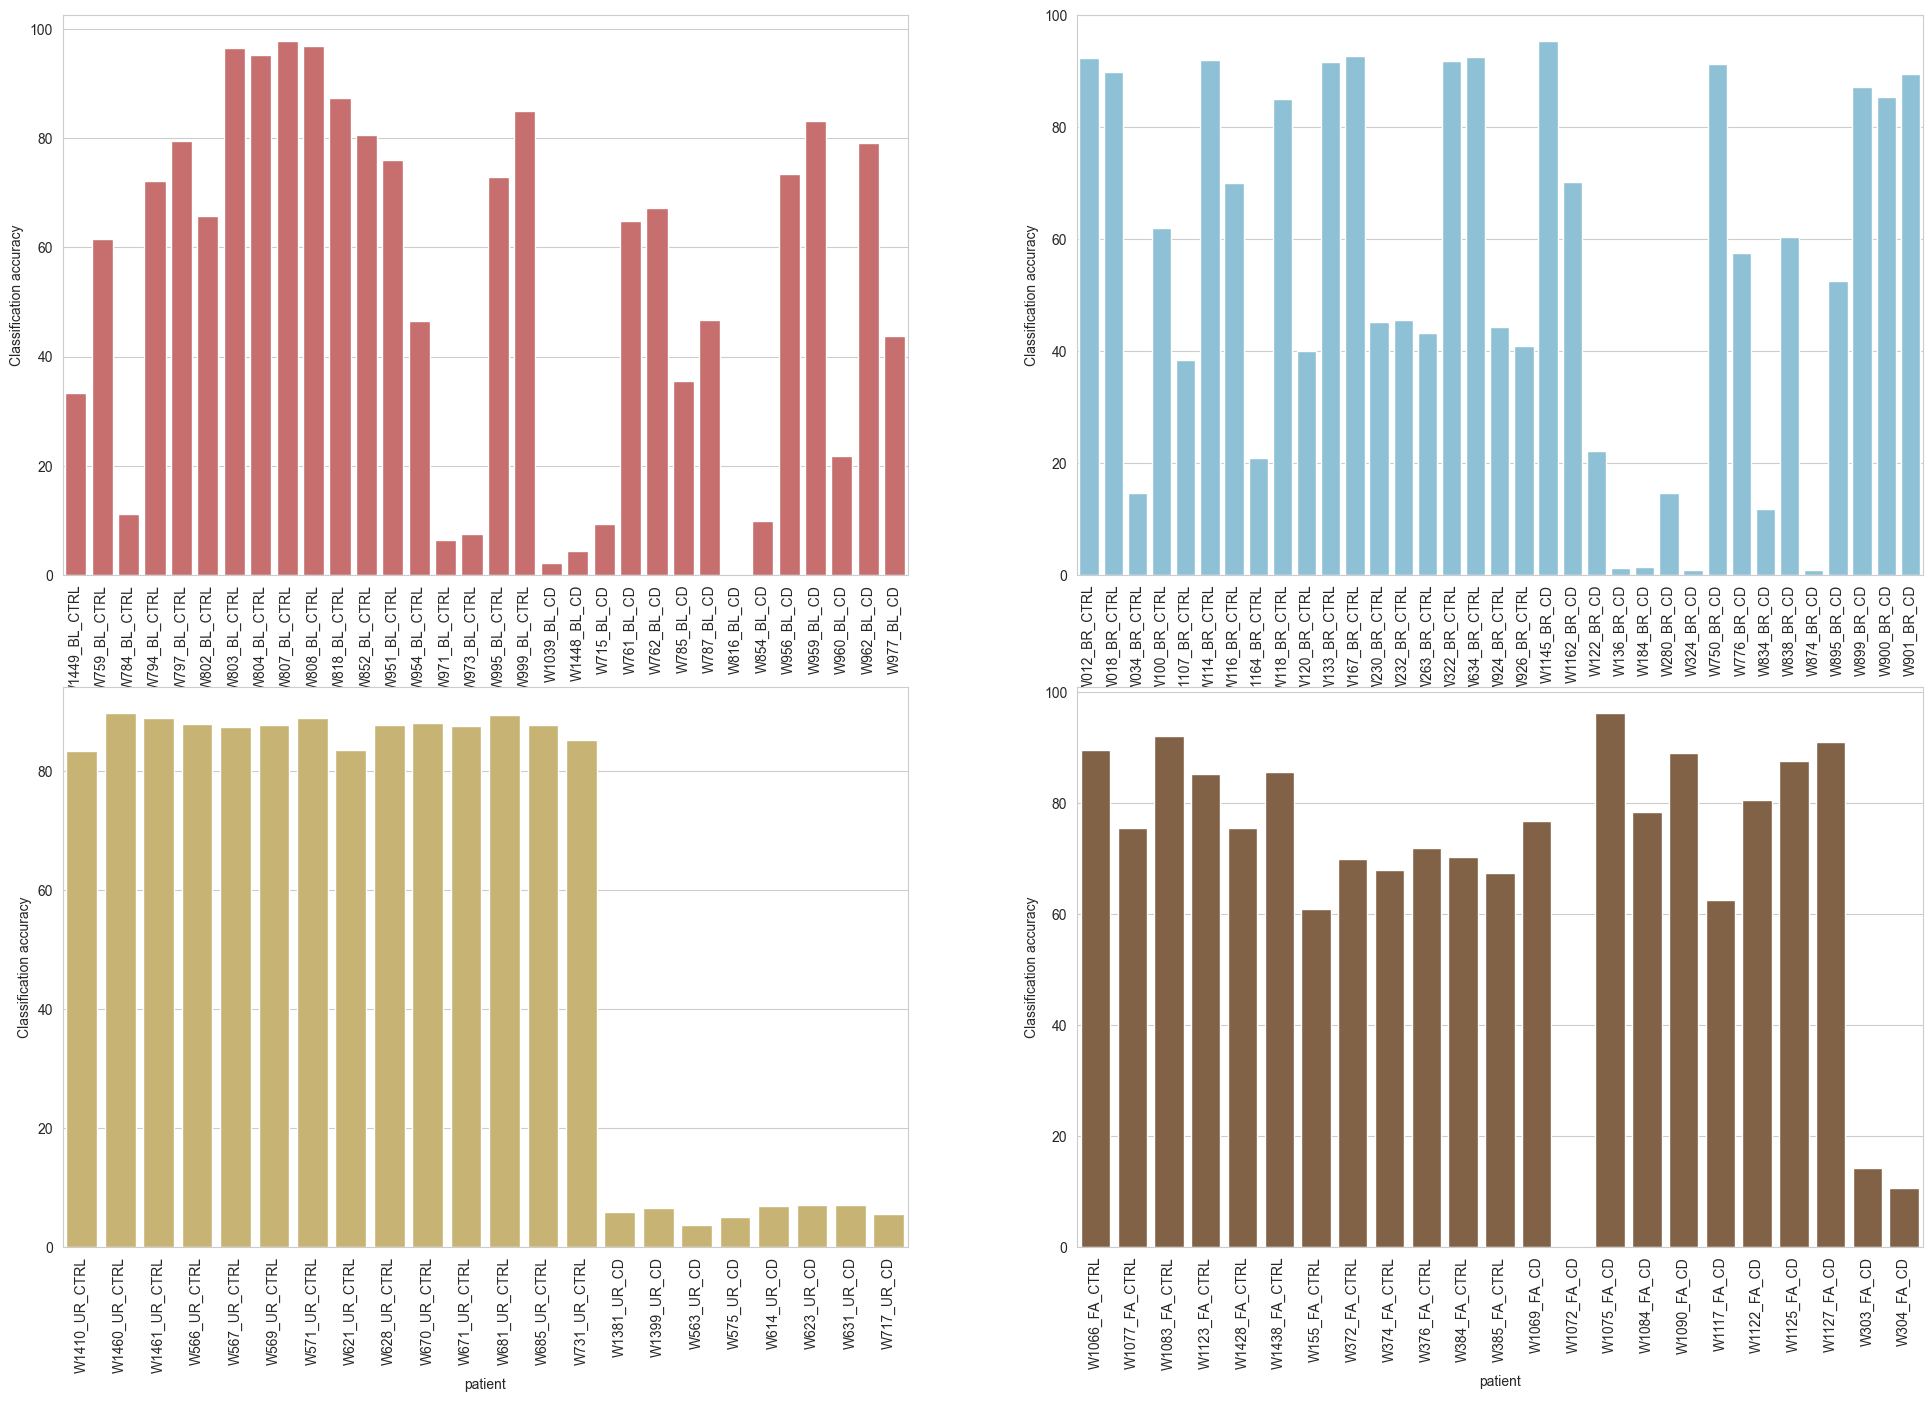

In [18]:
plot_patient_accuracies(bootstrap_results_d, sample_types, Xs)

### Faecal sample as best performing sample and testing RandomForestClassifier

In [19]:
X_train_fa, X_test_fa, y_train_fa, y_test_fa = train_test_split(fa_pca_array, y_faecal, test_size=0.25,
                 stratify=y_faecal, random_state=420)

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

forest = RandomForestClassifier(random_state = 420)

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 5, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train_fa, np.ravel(y_train_fa))
best_rf_predict = bestF.predict(X_test_fa)
print(classification_report(y_test_fa,best_rf_predict))

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6

